# MPL performance testing (number of neurons)

the main goal of this program is to determine if the number of neurons in the input layer contributes to improve the accuracy of the model

## Data processing

---

### Importing of libraries

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from time import process_time

### Importing of datasets

In [ ]:
training_set = pd.read_csv("../Datasets/train_mosaic.csv")
test_set = pd.read_csv("../Datasets/test_mosaic.csv")
sdn_set = pd.read_csv("../Datasets/dataset_sdn.csv")

### Data pre-processing

The main goal here is to separate the data into two main parts:  features (X_train/X_test) and  labels (Y_train/Y_test). 

In [ ]:
Y_train_3_labels = pd.DataFrame(training_set, columns=["Label"])
X_train = training_set.copy()
del X_train["Label"]
Y_test_3_labels = pd.DataFrame(test_set, columns=["Label"])
X_test = test_set.copy()
del X_test["Label"]

There are several labels in this dataset (DoS Hulk, DoS slowloris, BENIGN).Indeed, as we want to predict DDoS attacks we don't really need to differentiate the 2 different types of attacks. As a consequence, the goal here is to process the dataset in order to have only 2 labels available: BENIGN and DDoS


In [ ]:
Y_train = []
Y_test = []
# Processing of the training set
for label in Y_train_3_labels["Label"]:
  if label=="DoS Hulk" or label=="DoS slowloris":
    Y_train.append("DDoS")
  else:
    Y_train.append("BENIGN")

# Processing of the test set
for label in Y_test_3_labels["Label"]:
  if label=="DoS Hulk" or label=="DoS slowloris":
    Y_test.append("DDoS")
  else:
    Y_test.append("BENIGN")
X_train.shape

(809361, 77)

### Noisy data removing

In this part, the main objective is to remove all the non relevant data that could reduce the performance of the machine learning algorithm. The first step is to delete all the features with negative values because it does not make sense in this context.

In [ ]:
del X_train["Init_Win_bytes_backward"]
del X_train["Init_Win_bytes_forward"]
del X_test["Init_Win_bytes_backward"]
del X_test["Init_Win_bytes_forward"]
X_train.shape

(809361, 75)

The next set is to remove the constant features because it means that the values do not have any influence on the model prediction. In fact, whether it is a DDoS attack or not the value still the same.

In [ ]:
index = [32, 33, 49, 55, 56, 57, 58, 59, 60]
for pos in index: 
  feature = X_train.columns[pos]
  del X_train[feature]
  del X_test[feature]
X_train.shape

(809361, 66)

### Feature creation method (PCA)

In [ ]:
### Train set
pca = PCA(0.9)
X_pca_99 = pca.fit_transform(X_train)
rows, columns = X_pca_99.shape

### Test set
pca = PCA(0.9)
X_pca_99_test = pca.fit_transform(X_test)
print(X_pca_99_test.shape)

(346869, 3)


# MLP performance measures

---



The maim goal here is to determine if the performance increases when we change the default parameters of the model. Indeed, here we want to determine if the number of neurons in the input layer might be able to influence the accuracy of the model.

In [ ]:
neurons = [] 
for value in range(2,32,1):
  neurons.append(value)

featuresMeasured = ["Accuracy","Precision", "Recall", "TPR", "TNR", "FPR" , "FNR", "ProcessingTime"]
measuresInfo = {
  "Accuracy": [],
  "Precision": [],
  "Recall": [],
  "TPR": [],
  "TNR": [],
  "FPR": [],
  "FNR": [],
  "ProcessingTime":[],
}

for neuron in neurons:
  ## feature selection
  print("-------- Experimentation ",neuron," --------------")

  ## Model 
  clf = MLPClassifier(max_iter=600,hidden_layer_sizes=neuron,)
  start = process_time()
  clf.fit(X_pca_99, Y_train)
  end = process_time()
  Y_predict = clf.predict(X_pca_99_test)

  ## Metrix

  # Processing time
  training_time = end-start

  # accuracy
  accuracy = accuracy_score(Y_test, Y_predict)
  print("Accuracy --> ",accuracy)

  # Precision
  precision = precision_score(Y_test, Y_predict, average='macro')
  print("Precision score --> ",precision)

  # Recall
  recall = recall_score(Y_test, Y_predict, average='macro')
  print("Recall score --> ",recall)


  # Confusion matrix
  matrix = confusion_matrix(Y_test, Y_predict, labels=["DDoS", "BENIGN"])
  print(matrix)

  # TPR, FPR
  FP = matrix[0][0]
  FN = matrix[1][0]
  TP = matrix[1][1]
  TN = matrix[0][1]

  FP = FP.astype(float)
  FN = FN.astype(float)
  TP = TP.astype(float)
  TN = TN.astype(float)

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  # Specificity or true negative rate
  TNR = TN/(TN+FP) 
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  # False negative rate
  FNR = FN/(TP+FN)
  print("TPR --> ",TPR)
  print("TNR --> ",TNR)
  print("FPR --> ",FPR)
  print("FNR --> ",FNR)
  print("Processing time --> ",training_time)
  print("-----------------")

  #Information storage
  measuresInfo["Accuracy"].append(accuracy)
  measuresInfo["Precision"].append(precision)
  measuresInfo["Recall"].append(recall)
  measuresInfo["TPR"].append(TPR)
  measuresInfo["TNR"].append(TNR)
  measuresInfo["FPR"].append(FPR)
  measuresInfo["FNR"].append(FNR)
  measuresInfo["ProcessingTime"].append(training_time)
  print(measuresInfo)


-------- Experimentation  2  --------------
Accuracy -->  0.7596556625123606
Precision score -->  0.8242878711525607
Recall score -->  0.7773144927638327
[[105175  82399]
 [   969 158326]]
TPR -->  0.993916946545717
TNR -->  0.43928796101805156
FPR -->  0.5607120389819484
FNR -->  0.006083053454282934
Processing time -->  65.24628320599999
-----------------
{'Accuracy': [0.7596556625123606], 'Precision': [0.8242878711525607], 'Recall': [0.7773144927638327], 'TPR': [0.993916946545717], 'TNR': [0.43928796101805156], 'FPR': [0.5607120389819484], 'FNR': [0.006083053454282934], 'ProcessingTime': [65.24628320599999]}
-------- Experimentation  3  --------------
Accuracy -->  0.7536216842669711
Precision score -->  0.7989632814671179
Recall score -->  0.768745110470492
[[109401  78173]
 [  7288 152007]]
TPR -->  0.9542484070435355
TNR -->  0.41675818610255155
FPR -->  0.5832418138974484
FNR -->  0.04575159295646442
Processing time -->  45.34996028699999
-----------------
{'Accuracy': [0.759655

DataFrame export

In [ ]:
measuresInfoDF = pd.DataFrame(measuresInfo)
measuresInfoDF.to_csv('../Results/MLP/num_neurons/0.9/results.csv') 

Display of the metrics

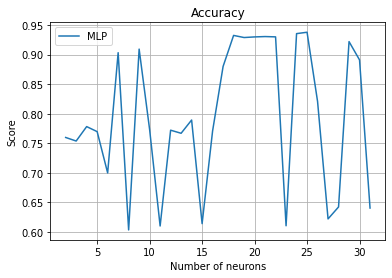

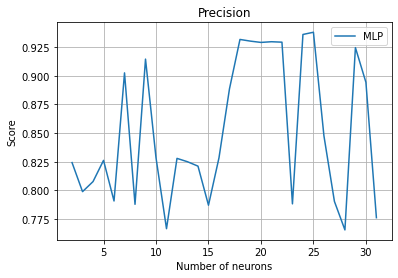

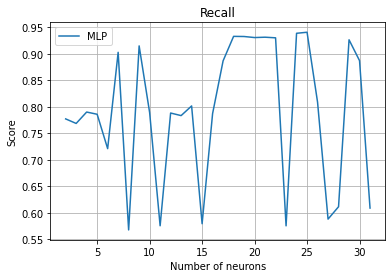

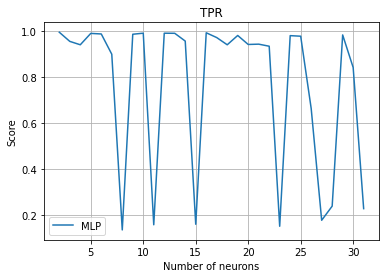

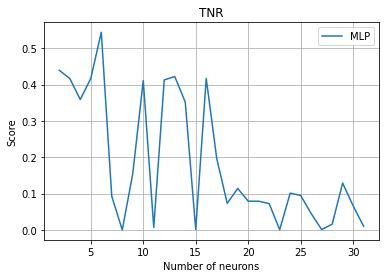

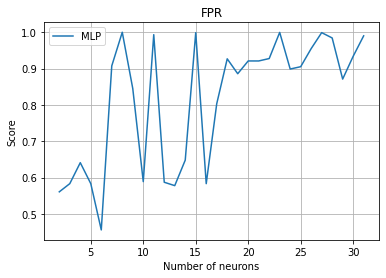

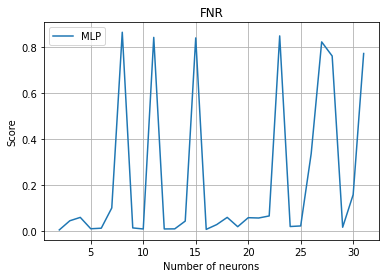

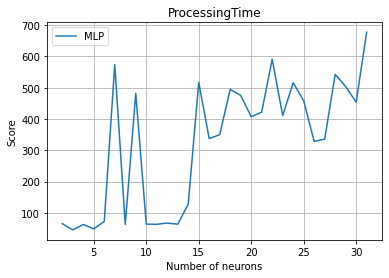

In [ ]:
compteur=0
for feature in featuresMeasured:
  plt.figure(compteur)
  plt.plot(neurons,measuresInfo[feature],label="MLP")
  plt.grid(True)
  plt.xlabel("Number of neurons")
  plt.ylabel("Score")
  plt.legend()
  plt.title(feature)
  chemin = "../Results/MLP/num_neurons/0.9/"+feature+".png"
  plt.savefig(chemin)
  compteur+=1